In [ ]:
# sarscov2 analysis  

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bmm_numba import BMMsNumba
from method_bmm_numba import BMMsNumba 
from scipy import stats
from scipy.stats import chi2_contingency

In [ ]:
## 1. Supp_Figure_7b --- ---

In [24]:
def subgenomix_BMM_2_clusters(p_min_samples): 

    f_dir = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/'

    sub1 = pd.read_csv('/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/new_X_EPI_ISL_407987_sg08_31596_0_1654.txt',sep='\t')
    sub2 = pd.read_csv('/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/new_X_EPI_ISL_407987_sg06_6110_0_2526.txt',sep='\t')

    flt1 =  sub1.drop(columns=['group'])
    flt1.index = flt1.iid
    flt1 = flt1.drop(columns=['iid']) 
    flt2 =  sub2.drop(columns=['group'])
    flt2.index = flt2.iid
    flt2 = flt2.drop(columns=['iid']) 

    ### to filter out reads based on mutation

    np.random.seed(386) #386, 472, 123
    p_clusters = 2 
    f_likelihood = None
    p_no_of_runs = 1
    p_threshold = 0.5 #0.0001
    p_min_iters = 20 #300 #300

    df_WT_flt1 =  flt1.iloc[:,1273:1495]
    df_MT_flt1 =  flt2.iloc[:,2145:2367]

    
    p_length = 222
    p_lower = int(0.0075 * p_length)
    p_upper = int(0.035 * p_length)

    df_WT_flt1 = df_WT_flt1.loc[(df_WT_flt1.sum(axis=1)>=p_lower)&(df_WT_flt1.sum(axis=1)<=p_upper),:]
    df_MT_flt1 = df_MT_flt1.loc[(df_MT_flt1.sum(axis=1)>=p_lower)&(df_MT_flt1.sum(axis=1)<=p_upper),:]

    ### D. to subsample for downstream BMM cluster
    df_WT_flt2 = df_WT_flt1.sample(2000, random_state=386)
    df_MT_flt2 = df_MT_flt1.sample(0, random_state=386)
 
    # add save the observed data after filter
    df_WT_flt2.to_csv(f_dir  + 'sg08_sample_window_600.txt',sep='\t')
    df_MT_flt2.to_csv(f_dir  + 'sg06_sample_window_600.txt',sep='\t')

    df_WT_flt2.columns = range(1273+28273,1495+28273)
    df_MT_flt2.columns = range(1273+28273,1495+28273)
    new_X = pd.concat([df_WT_flt2, df_MT_flt2])
    print(new_X.shape)
    new_X.to_csv(f_dir  + 'new_X_sg08_vs_sg06_sample_window_draco.txt',sep='\t')

    # Prepare extra parameters for 
    #params = [pd.concat([df_WT_flt1, df_MT_flt1]), df_WT_flt1, df_MT_flt1, p_start, p_end, p_local]

    ### E. BMM results
    dict_results = {}
    output_BIC = []
    for p_cluster in range(2, 2+1):

        bmm = BMMsNumba(n_clusters=p_cluster, f_likelihood=f_likelihood)
        model = bmm.fit(new_X.values, #[50:-50]
                        no_of_runs=p_no_of_runs,
                        thrshld_ll=p_threshold,
                        min_iters=p_min_iters)
        states = model.predict()
        print(p_cluster, model.BIC)
        output_BIC.append(model.BIC)

        results = []
        for i in range(p_cluster):
            results.append(np.where(model.labels_ == i)[0].tolist())

        dict_results[p_cluster] = results

    X_pred_WT = new_X.iloc[results[0],:]
    X_pred_MT = new_X.iloc[results[1],:]

    ### subclusters from BMM 
    X_pred_WT_inWT = X_pred_WT[X_pred_WT.index.isin(df_WT_flt2.index)]
    X_pred_WT_inMT = X_pred_WT[X_pred_WT.index.isin(df_MT_flt2.index)]

    X_pred_MT_inMT = X_pred_MT[X_pred_MT.index.isin(df_MT_flt2.index)]
    X_pred_MT_inWT = X_pred_MT[X_pred_MT.index.isin(df_WT_flt2.index)]

    ### to save the predicted results
    
    X_pred_WT_inWT['group'] = 'X_pred_WT_inWT'
    X_pred_WT_inMT['group'] = 'X_pred_WT_inMT'
    X_pred_MT_inWT['group'] = 'X_pred_MT_inWT'
    X_pred_MT_inMT['group'] = 'X_pred_MT_inMT'
    pred_all = pd.concat([X_pred_WT_inWT,X_pred_WT_inMT,X_pred_MT_inWT,X_pred_MT_inMT])
    pred_all.to_csv(f_dir  + 'X_pred_sg08_vs_sg06_sample_window_draco.txt',sep='\t')
    
    return df_WT_flt2, df_MT_flt2, new_X, pred_all, X_pred_WT, X_pred_MT 

In [25]:
new_X1, new_X2, new_X, pred, X_pred_WT, X_pred_MT = subgenomix_BMM_2_clusters(1000)

(2000, 222)
Current Run: 0
Best Model - Run 0
2 49430.64347635211


In [26]:
def plot_window_long(window):  

    dir =  '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/'
    pred = pd.read_csv(dir+'X_pred_sg08_vs_sg06_sample_window_draco.txt',sep='\t')

    #clusters = ['X_pred_WT_inWT', 'X_pred_WT_inMT', 'X_pred_MT_inWT','X_pred_MT_inMT']
    flt = pred[(pred['group'] == 'X_pred_WT_inWT') | (pred['group'] == 'X_pred_WT_inMT')]
    X_pred_WT_inWT = flt.drop(columns=['iid','group'])

    flt = pred[(pred['group'] == 'X_pred_MT_inWT') | (pred['group'] == 'X_pred_MT_inMT')]
    X_pred_MT_inWT = flt.drop(columns=['iid','group'])

    # cluster0

    fig, ax = plt.subplots(2, 1, figsize=(10, 6), 
                                gridspec_kw={
                            'height_ratios': [2, 2],
                            'hspace': 0.25
                            },
                        sharex=True, sharey=False)

    ax[0].set_facecolor("white")
    ax[0].plot(range(29546, X_pred_WT_inWT.shape[1]+29546), X_pred_WT_inWT.sum(axis=0)/X_pred_WT_inWT.shape[0], color = colors[0], linewidth=2)
    ax[0].set_title('Cluster 0 (n=' + str(X_pred_WT_inWT.shape[0])+')', fontsize=16)
    ax[0].set_ylabel('Mod rate',fontsize=14)
    ax[0].set_ylim(0,0.15)
    ax[0].grid(False)

    ax[1].set_facecolor("white")
    ax[1].plot(range(29546,X_pred_MT_inWT.shape[1]+29546), X_pred_MT_inWT.sum(axis=0)/X_pred_MT_inWT.shape[0], color = colors[1], linewidth=2)
    ax[1].set_title('Cluster 1 (n=' + str(X_pred_MT_inWT.shape[0])+')', fontsize=16)
    ax[1].set_ylabel('Mod rate',fontsize=14)
    ax[1].set_ylim(0,0.15)
    ax[1].grid(False)

    fig.suptitle('', fontsize=20)


    # cluster0

    fig, ax = plt.subplots(2, 1, figsize=(10, 6), 
                                gridspec_kw={
                            'height_ratios': [1, 3],
                            'hspace': 0.05
                            },
                        sharex=True, sharey=False)

    ax[0].set_facecolor("white")
    ax[0].plot(range(X_pred_WT_inWT.shape[1]), X_pred_WT_inWT.sum(axis=0)/X_pred_WT_inWT.shape[0], color = colors[0], linewidth=2)
    ax[0].set_title('Cluster 0 (n=' + str(X_pred_WT_inWT.shape[0])+')', fontsize=16)
    ax[0].set_ylabel('Mod rate',fontsize=14)
    ax[0].set_ylim(0,0.15)
    ax[0].grid(False)

    ## 1. figs
    flt = pred[(pred['group'] == 'X_pred_WT_inWT') | (pred['group'] == 'X_pred_WT_inMT')]
    dplot = flt.drop(columns=['iid','group'])

    cmap = sns.cm.rocket_r
    sns.heatmap(dplot,cmap = cmap,ax=ax[1],cbar=False)

    ax[1].set_ylabel('read index',fontsize=14)
    ax[1].set_title('')
    fig.suptitle('', fontsize=20)
    
    dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/'
    plt.savefig(dir_out+'Supp_Figure_7b_N_cluster0.pdf',bbox_inches='tight', dpi=300) 

    # cluster1
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), 
                                gridspec_kw={
                            'height_ratios': [1, 3],
                            'hspace': 0.05
                            },
                        sharex=True, sharey=False)

    ax[0].set_facecolor("white")
    ax[0].plot(range(X_pred_MT_inWT.shape[1]), X_pred_MT_inWT.sum(axis=0)/X_pred_MT_inWT.shape[0], color = colors[1], linewidth=2)
    ax[0].set_title('Cluster 1 (n=' + str(X_pred_MT_inWT.shape[0])+')', fontsize=16)
    ax[0].set_ylabel('Mod rate',fontsize=14)
    ax[0].set_ylim(0,0.15)
    ax[0].grid(False)

    ## 1. figs
    flt = pred[(pred['group'] == 'X_pred_MT_inWT') | (pred['group'] == 'X_pred_MT_inMT')]
    dplot = flt.drop(columns=['iid','group'])

    cmap = sns.cm.rocket_r
    sns.heatmap(dplot,cmap = cmap,ax=ax[1],cbar=False)

    ax[1].set_ylabel('read index',fontsize=14)
    ax[1].set_title('')
    fig.suptitle('', fontsize=20)

    dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/'
    plt.savefig(dir_out+'Supp_Figure_7b_N_cluster1.pdf',bbox_inches='tight', dpi=300) 

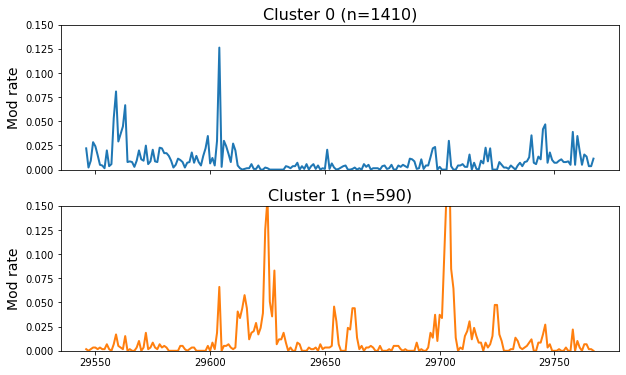

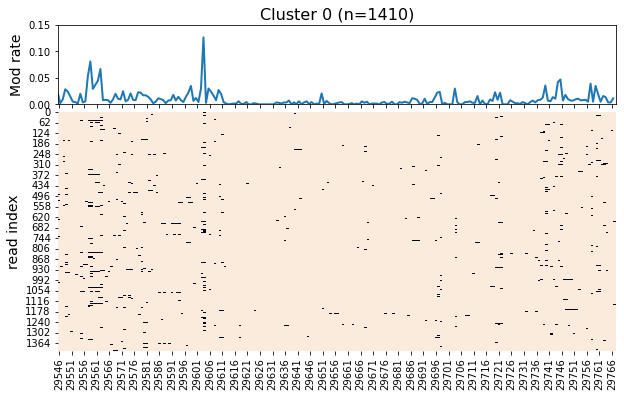

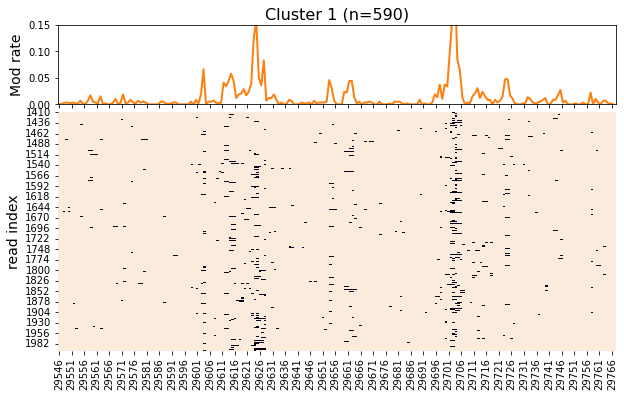

In [27]:
plot_window_long('')

In [ ]:
### ORF7a --------------------------------
### ORF7a --------------------------------

In [6]:
def subgenomix_BMM_2_clusters(p_min_samples): 
    
    f_dir = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/'

    sub1 = pd.read_csv('/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/new_X_EPI_ISL_407987_sg08_31596_0_1654.txt',sep='\t')
    sub2 = pd.read_csv('/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/new_X_EPI_ISL_407987_sg06_6110_0_2526.txt',sep='\t')

    flt1 =  sub1.drop(columns=['group'])
    flt1.index = flt1.iid
    flt1 = flt1.drop(columns=['iid']) 
    flt2 =  sub2.drop(columns=['group'])
    flt2.index = flt2.iid
    flt2 = flt2.drop(columns=['iid']) 

    ### to filter out reads based on mutation

    np.random.seed(386) #386, 472, 123
    p_clusters = 2 
    f_likelihood = None
    p_no_of_runs = 1
    p_threshold = 0.5 #0.0001
    p_min_iters = 20 #300 #300

    df_WT_flt1 =  flt1.iloc[:,1273:1495]
    df_MT_flt1 =  flt2.iloc[:,2145:2367]


    p_length = 222
    p_lower = int(0.0075 * p_length)
    p_upper = int(0.035 * p_length)

    df_WT_flt1 = df_WT_flt1.loc[(df_WT_flt1.sum(axis=1)>=p_lower)&(df_WT_flt1.sum(axis=1)<=p_upper),:]
    df_MT_flt1 = df_MT_flt1.loc[(df_MT_flt1.sum(axis=1)>=p_lower)&(df_MT_flt1.sum(axis=1)<=p_upper),:]

    ### D. to subsample for downstream BMM cluster
    df_WT_flt2 = df_WT_flt1.sample(0, random_state=386)
    df_MT_flt2 = df_MT_flt1.sample(2000, random_state=386)
 
    # add save the observed data after filter
    df_WT_flt2.to_csv(f_dir  + 'sg08_sample_window_600.txt',sep='\t')
    df_MT_flt2.to_csv(f_dir  + 'sg06_sample_window_600.txt',sep='\t')

    df_WT_flt2.columns = range(1273+28273,1495+28273)
    df_MT_flt2.columns = range(1273+28273,1495+28273)
    new_X = pd.concat([df_WT_flt2, df_MT_flt2])
    print(new_X.shape)
    new_X.to_csv(f_dir  + 'new_X_sg08_vs_sg06_sample_window_draco.txt',sep='\t')

    # Prepare extra parameters for 
    #params = [pd.concat([df_WT_flt1, df_MT_flt1]), df_WT_flt1, df_MT_flt1, p_start, p_end, p_local]

    ### E. BMM results
    dict_results = {}
    output_BIC = []
    for p_cluster in range(2, 2+1):

        bmm = BMMsNumba(n_clusters=p_cluster, f_likelihood=f_likelihood)
        model = bmm.fit(new_X.values, #[50:-50]
                        no_of_runs=p_no_of_runs,
                        thrshld_ll=p_threshold,
                        min_iters=p_min_iters)
        states = model.predict()
        print(p_cluster, model.BIC)
        output_BIC.append(model.BIC)

        results = []
        for i in range(p_cluster):
            results.append(np.where(model.labels_ == i)[0].tolist())

        dict_results[p_cluster] = results

    X_pred_WT = new_X.iloc[results[0],:]
    X_pred_MT = new_X.iloc[results[1],:]

    ### subclusters from BMM 
    X_pred_WT_inWT = X_pred_WT[X_pred_WT.index.isin(df_WT_flt2.index)]
    X_pred_WT_inMT = X_pred_WT[X_pred_WT.index.isin(df_MT_flt2.index)]

    X_pred_MT_inMT = X_pred_MT[X_pred_MT.index.isin(df_MT_flt2.index)]
    X_pred_MT_inWT = X_pred_MT[X_pred_MT.index.isin(df_WT_flt2.index)]

    ### to save the predicted results
    
    X_pred_WT_inWT['group'] = 'X_pred_WT_inWT'
    X_pred_WT_inMT['group'] = 'X_pred_WT_inMT'
    X_pred_MT_inWT['group'] = 'X_pred_MT_inWT'
    X_pred_MT_inMT['group'] = 'X_pred_MT_inMT'
    pred_all = pd.concat([X_pred_WT_inWT,X_pred_WT_inMT,X_pred_MT_inWT,X_pred_MT_inMT])
    pred_all.to_csv(f_dir  + 'X_pred_sg08_vs_sg06_sample_window_draco.txt',sep='\t')
    
    return df_WT_flt2, df_MT_flt2, new_X, pred_all, X_pred_WT, X_pred_MT 

In [7]:
new_X1, new_X2, new_X, pred, X_pred_WT, X_pred_MT = subgenomix_BMM_2_clusters(1000) 

(2000, 222)
Current Run: 0
Best Model - Run 0
2 48643.55197871484


In [8]:
def plot_window_long(window):  

    dir =  '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/'
    pred = pd.read_csv(dir+'X_pred_sg08_vs_sg06_sample_window_draco.txt',sep='\t')

    
    flt = pred[(pred['group'] == 'X_pred_WT_inWT') | (pred['group'] == 'X_pred_WT_inMT')]
    X_pred_WT_inWT = flt.drop(columns=['iid','group'])

    flt = pred[(pred['group'] == 'X_pred_MT_inWT') | (pred['group'] == 'X_pred_MT_inMT')]
    X_pred_MT_inWT = flt.drop(columns=['iid','group'])

    # cluster0

    fig, ax = plt.subplots(2, 1, figsize=(10, 6), 
                                gridspec_kw={
                            'height_ratios': [2, 2],
                            'hspace': 0.25
                            },
                        sharex=True, sharey=False)

    ax[0].set_facecolor("white")
    ax[0].plot(range(29546, X_pred_WT_inWT.shape[1]+29546), X_pred_WT_inWT.sum(axis=0)/X_pred_WT_inWT.shape[0], color = colors[0], linewidth=2)
    ax[0].set_title('Cluster 0 (n=' + str(X_pred_WT_inWT.shape[0])+')', fontsize=16)
    ax[0].set_ylabel('Mod rate',fontsize=14)
    ax[0].set_ylim(0,0.15)
    ax[0].grid(False)

    ax[1].set_facecolor("white")
    ax[1].plot(range(29546,X_pred_MT_inWT.shape[1]+29546), X_pred_MT_inWT.sum(axis=0)/X_pred_MT_inWT.shape[0], color = colors[1], linewidth=2)
    ax[1].set_title('Cluster 1 (n=' + str(X_pred_MT_inWT.shape[0])+')', fontsize=16)
    ax[1].set_ylabel('Mod rate',fontsize=14)
    ax[1].set_ylim(0,0.15)
    ax[1].grid(False)

    fig.suptitle('', fontsize=20)


    # cluster0

    fig, ax = plt.subplots(2, 1, figsize=(10, 6), 
                                gridspec_kw={
                            'height_ratios': [1, 3],
                            'hspace': 0.05
                            },
                        sharex=True, sharey=False)

    ax[0].set_facecolor("white")
    ax[0].plot(range(X_pred_WT_inWT.shape[1]), X_pred_WT_inWT.sum(axis=0)/X_pred_WT_inWT.shape[0], color = colors[0], linewidth=2)
    ax[0].set_title('Cluster 0 (n=' + str(X_pred_WT_inWT.shape[0])+')', fontsize=16)
    ax[0].set_ylabel('Mod rate',fontsize=14)
    ax[0].set_ylim(0,0.15)
    ax[0].grid(False)

    ## 1. figs
    flt = pred[(pred['group'] == 'X_pred_WT_inWT') | (pred['group'] == 'X_pred_WT_inMT')]
    dplot = flt.drop(columns=['iid','group'])

    cmap = sns.cm.rocket_r
    sns.heatmap(dplot,cmap = cmap,ax=ax[1],cbar=False)

    ax[1].set_ylabel('read index',fontsize=14)
    ax[1].set_title('')
    fig.suptitle('', fontsize=20)

    dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/'
    plt.savefig(dir_out+'Supp_Figure_7b_ORF7a_cluster0.pdf',bbox_inches='tight', dpi=300) 
    
    

    # cluster1
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), 
                                gridspec_kw={
                            'height_ratios': [1, 3],
                            'hspace': 0.05
                            },
                        sharex=True, sharey=False)

    ax[0].set_facecolor("white")
    ax[0].plot(range(X_pred_MT_inWT.shape[1]), X_pred_MT_inWT.sum(axis=0)/X_pred_MT_inWT.shape[0], color = colors[1], linewidth=2)
    ax[0].set_title('Cluster 1 (n=' + str(X_pred_MT_inWT.shape[0])+')', fontsize=16)
    ax[0].set_ylabel('Mod rate',fontsize=14)
    ax[0].set_ylim(0,0.15)
    ax[0].grid(False)

    ## 1. figs
    flt = pred[(pred['group'] == 'X_pred_MT_inWT') | (pred['group'] == 'X_pred_MT_inMT')]
    dplot = flt.drop(columns=['iid','group'])

    cmap = sns.cm.rocket_r
    sns.heatmap(dplot,cmap = cmap,ax=ax[1],cbar=False)

    ax[1].set_ylabel('read index',fontsize=14)
    ax[1].set_title('')
    fig.suptitle('', fontsize=20)
    dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/'
    plt.savefig(dir_out+'Supp_Figure_7b_ORF7a_cluster1.pdf',bbox_inches='tight', dpi=300) 

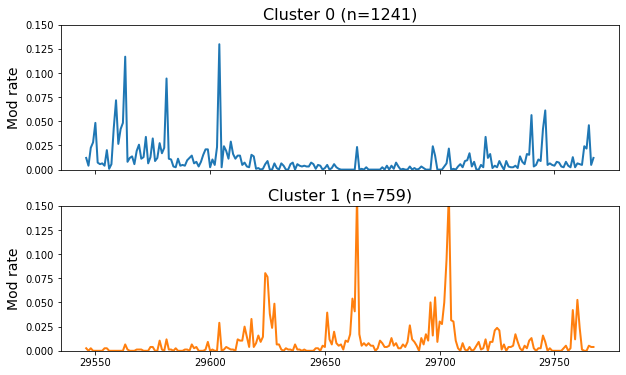

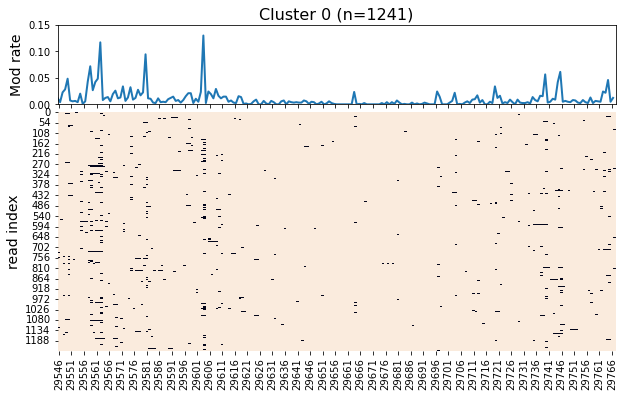

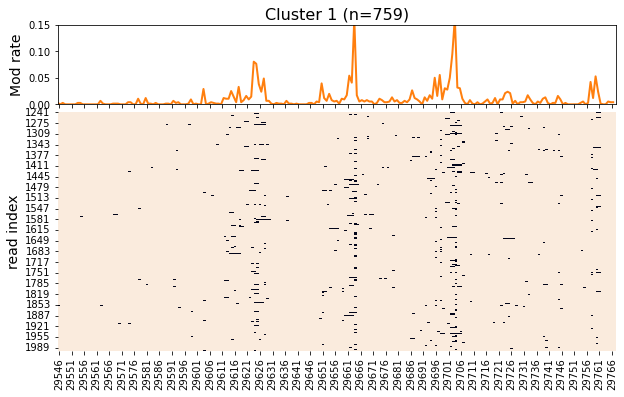

In [9]:
plot_window_long('')

In [ ]:
### ORF8 ------------------------------
### ORF8  -----------------------------

In [ ]:
sub1 = pd.read_csv('/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/new_X_EPI_ISL_407987_sg08_31596_0_1654.txt',sep='\t')
sub2 = pd.read_csv('/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/new_X_EPI_ISL_407987_sg07_3483_0_2026.txt',sep='\t')
sub3 = pd.read_csv('/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/new_X_EPI_ISL_407987_sg06_6110_0_2526.txt',sep='\t')

In [10]:
def subgenomix_BMM_2_clusters(p_min_samples): 

    f_dir = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/'

    sub1 = pd.read_csv('/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/new_X_EPI_ISL_407987_sg08_31596_0_1654.txt',sep='\t')
    sub2 = pd.read_csv('/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/new_X_EPI_ISL_407987_sg07_3483_0_2026.txt',sep='\t')

    flt1 =  sub1.drop(columns=['group'])
    flt1.index = flt1.iid
    flt1 = flt1.drop(columns=['iid']) 
    flt2 =  sub2.drop(columns=['group'])
    flt2.index = flt2.iid
    flt2 = flt2.drop(columns=['iid']) 

    ### to filter out reads based on mutation

    np.random.seed(386) #386, 472, 123
    p_clusters = 2 
    f_likelihood = None
    p_no_of_runs = 1
    p_threshold = 0.5 #0.0001
    p_min_iters = 20 #300 #300

    df_WT_flt1 =  flt1.iloc[:,1273:1495]
    df_MT_flt1 =  flt2.iloc[:,1645:1867]


    p_length = 222
    p_lower = int(0.0075 * p_length)
    p_upper = int(0.035 * p_length)

    df_WT_flt1 = df_WT_flt1.loc[(df_WT_flt1.sum(axis=1)>=p_lower)&(df_WT_flt1.sum(axis=1)<=p_upper),:]
    df_MT_flt1 = df_MT_flt1.loc[(df_MT_flt1.sum(axis=1)>=p_lower)&(df_MT_flt1.sum(axis=1)<=p_upper),:]

    ### D. to subsample for downstream BMM cluster
    print(df_WT_flt1.shape)
    print(df_MT_flt1.shape)
    df_WT_flt2 = df_WT_flt1.sample(0, random_state=386)
    df_MT_flt2 = df_MT_flt1.sample(2000, random_state=386, replace=True)
 
    # add save the observed data after filter
    df_WT_flt2.to_csv(f_dir  + 'sg08_sample_window_600.txt',sep='\t')
    df_MT_flt2.to_csv(f_dir  + 'sg06_sample_window_600.txt',sep='\t')

    df_WT_flt2.columns = range(1273+28273,1495+28273)
    df_MT_flt2.columns = range(1273+28273,1495+28273)
    new_X = pd.concat([df_WT_flt2, df_MT_flt2])
    print(new_X.shape)
    new_X.to_csv(f_dir  + 'new_X_sg08_vs_sg06_sample_window_draco.txt',sep='\t')

    # Prepare extra parameters for 
    #params = [pd.concat([df_WT_flt1, df_MT_flt1]), df_WT_flt1, df_MT_flt1, p_start, p_end, p_local]

    ### E. BMM results
    dict_results = {}
    output_BIC = []
    for p_cluster in range(2, 2+1):

        bmm = BMMsNumba(n_clusters=p_cluster, f_likelihood=f_likelihood)
        model = bmm.fit(new_X.values, #[50:-50]
                        no_of_runs=p_no_of_runs,
                        thrshld_ll=p_threshold,
                        min_iters=p_min_iters)
        states = model.predict()
        print(p_cluster, model.BIC)
        output_BIC.append(model.BIC)

        results = []
        for i in range(p_cluster):
            results.append(np.where(model.labels_ == i)[0].tolist())

        dict_results[p_cluster] = results

    X_pred_WT = new_X.iloc[results[0],:]
    X_pred_MT = new_X.iloc[results[1],:]

    ### subclusters from BMM 
    X_pred_WT_inWT = X_pred_WT[X_pred_WT.index.isin(df_WT_flt2.index)]
    X_pred_WT_inMT = X_pred_WT[X_pred_WT.index.isin(df_MT_flt2.index)]

    X_pred_MT_inMT = X_pred_MT[X_pred_MT.index.isin(df_MT_flt2.index)]
    X_pred_MT_inWT = X_pred_MT[X_pred_MT.index.isin(df_WT_flt2.index)]

    ### to save the predicted results
    
    X_pred_WT_inWT['group'] = 'X_pred_WT_inWT'
    X_pred_WT_inMT['group'] = 'X_pred_WT_inMT'
    X_pred_MT_inWT['group'] = 'X_pred_MT_inWT'
    X_pred_MT_inMT['group'] = 'X_pred_MT_inMT'
    pred_all = pd.concat([X_pred_WT_inWT,X_pred_WT_inMT,X_pred_MT_inWT,X_pred_MT_inMT])
    pred_all.to_csv(f_dir  + 'X_pred_sg08_vs_sg06_sample_window_draco.txt',sep='\t')
    
    return df_WT_flt2, df_MT_flt2, new_X, pred_all, X_pred_WT, X_pred_MT 

In [11]:
new_X1, new_X2, new_X, pred, X_pred_WT, X_pred_MT = subgenomix_BMM_2_clusters(1000) 

(18887, 222)
(2175, 222)
(2000, 222)
Current Run: 0
Best Model - Run 0
2 50517.19768588731


In [12]:
def plot_window_long(window):  

    dir =  '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/'
    pred = pd.read_csv(dir+'X_pred_sg08_vs_sg06_sample_window_draco.txt',sep='\t')

    #clusters = ['X_pred_WT_inWT', 'X_pred_WT_inMT', 'X_pred_MT_inWT','X_pred_MT_inMT']
    flt = pred[(pred['group'] == 'X_pred_WT_inWT') | (pred['group'] == 'X_pred_WT_inMT')]
    X_pred_WT_inWT = flt.drop(columns=['iid','group'])

    flt = pred[(pred['group'] == 'X_pred_MT_inWT') | (pred['group'] == 'X_pred_MT_inMT')]
    X_pred_MT_inWT = flt.drop(columns=['iid','group'])

    # cluster0

    fig, ax = plt.subplots(2, 1, figsize=(10, 6), 
                                gridspec_kw={
                            'height_ratios': [2, 2],
                            'hspace': 0.25
                            },
                        sharex=True, sharey=False)

    ax[0].set_facecolor("white")
    ax[0].plot(range(29200, X_pred_WT_inWT.shape[1]+29200), X_pred_WT_inWT.sum(axis=0)/X_pred_WT_inWT.shape[0], color = colors[0], linewidth=2)
    ax[0].set_title('Cluster 0 (n=' + str(X_pred_WT_inWT.shape[0])+')', fontsize=16)
    ax[0].set_ylabel('Mod rate',fontsize=14)
    ax[0].set_ylim(0,0.15)
    ax[0].grid(False)

    ax[1].set_facecolor("white")
    ax[1].plot(range(29200,X_pred_MT_inWT.shape[1]+29200), X_pred_MT_inWT.sum(axis=0)/X_pred_MT_inWT.shape[0], color = colors[1], linewidth=2)
    ax[1].set_title('Cluster 1 (n=' + str(X_pred_MT_inWT.shape[0])+')', fontsize=16)
    ax[1].set_ylabel('Mod rate',fontsize=14)
    ax[1].set_ylim(0,0.15)
    ax[1].grid(False)

    fig.suptitle('', fontsize=20)


    # cluster0

    fig, ax = plt.subplots(2, 1, figsize=(10, 6), 
                                gridspec_kw={
                            'height_ratios': [1, 3],
                            'hspace': 0.05
                            },
                        sharex=True, sharey=False)

    ax[0].set_facecolor("white")
    ax[0].plot(range(X_pred_WT_inWT.shape[1]), X_pred_WT_inWT.sum(axis=0)/X_pred_WT_inWT.shape[0], color = colors[0], linewidth=2)
    ax[0].set_title('Cluster 0 (n=' + str(X_pred_WT_inWT.shape[0])+')', fontsize=16)
    ax[0].set_ylabel('Mod rate',fontsize=14)
    ax[0].set_ylim(0,0.15)
    ax[0].grid(False)

    ## 1. figs
    flt = pred[(pred['group'] == 'X_pred_WT_inWT') | (pred['group'] == 'X_pred_WT_inMT')]
    dplot = flt.drop(columns=['iid','group'])

    cmap = sns.cm.rocket_r
    sns.heatmap(dplot,cmap = cmap,ax=ax[1],cbar=False)

    ax[1].set_ylabel('read index',fontsize=14)
    ax[1].set_title('')
    fig.suptitle('', fontsize=20)

    dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/'
    plt.savefig(dir_out+'Supp_Figure_7b_ORF8_cluster0.pdf',bbox_inches='tight', dpi=300) 



    # cluster1
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), 
                                gridspec_kw={
                            'height_ratios': [1, 3],
                            'hspace': 0.05
                            },
                        sharex=True, sharey=False)

    ax[0].set_facecolor("white")
    ax[0].plot(range(X_pred_MT_inWT.shape[1]), X_pred_MT_inWT.sum(axis=0)/X_pred_MT_inWT.shape[0], color = colors[1], linewidth=2)
    ax[0].set_title('Cluster 1 (n=' + str(X_pred_MT_inWT.shape[0])+')', fontsize=16)
    ax[0].set_ylabel('Mod rate',fontsize=14)
    ax[0].set_ylim(0,0.15)
    ax[0].grid(False)

    ## 1. figs
    flt = pred[(pred['group'] == 'X_pred_MT_inWT') | (pred['group'] == 'X_pred_MT_inMT')]
    dplot = flt.drop(columns=['iid','group'])

    cmap = sns.cm.rocket_r
    sns.heatmap(dplot,cmap = cmap,ax=ax[1],cbar=False)

    ax[1].set_ylabel('read index',fontsize=14)
    ax[1].set_title('')
    fig.suptitle('', fontsize=20)
    dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/'
    plt.savefig(dir_out+'Supp_Figure_7b_ORF8_cluster1.pdf',bbox_inches='tight', dpi=300) 

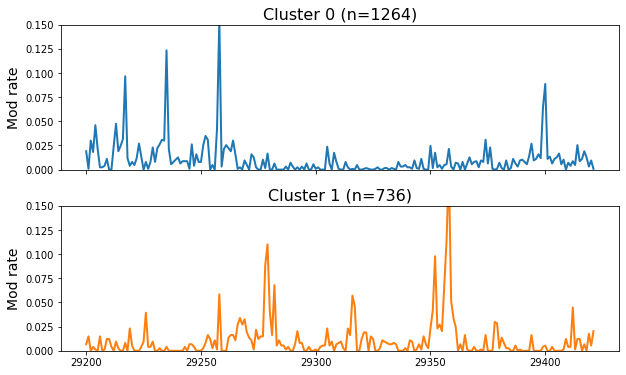

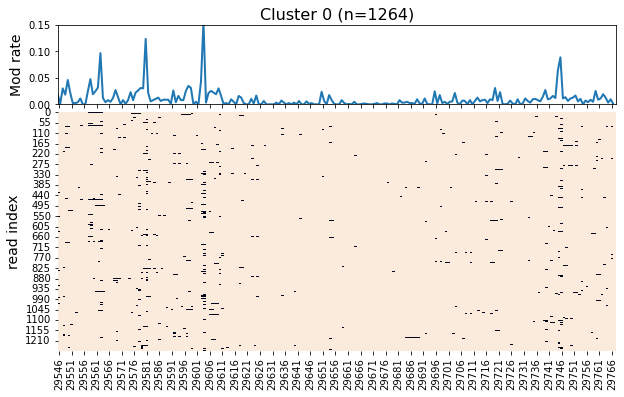

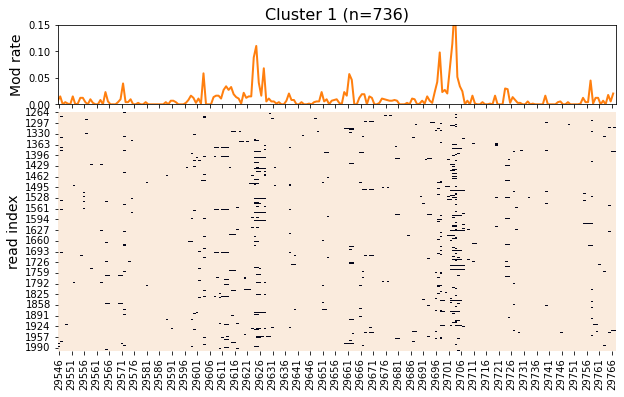

In [13]:
plot_window_long('')

In [ ]:
### ensemble all 3 mix ---------------------------------
### ensemble all 3 mix  --------------------------------

In [14]:
def subgenomix_BMM_2_clusters(p_min_samples): 

    f_dir = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/'

    sub1 = pd.read_csv('/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/new_X_EPI_ISL_407987_sg08_31596_0_1654.txt',sep='\t')
    sub2 = pd.read_csv('/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/new_X_EPI_ISL_407987_sg07_3483_0_2026.txt',sep='\t')
    sub3 = pd.read_csv('/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/new_X_EPI_ISL_407987_sg06_6110_0_2526.txt',sep='\t')
    

    flt1 =  sub1.drop(columns=['group'])
    flt1.index = flt1.iid
    flt1 = flt1.drop(columns=['iid']) 
    flt2 =  sub2.drop(columns=['group'])
    flt2.index = flt2.iid
    flt2 = flt2.drop(columns=['iid']) 
    flt3 =  sub3.drop(columns=['group'])
    flt3.index = flt3.iid
    flt3 = flt3.drop(columns=['iid']) 

    ### to filter out reads based on mutation

    np.random.seed(386) #386, 472, 123
    p_clusters = 2 
    f_likelihood = None
    p_no_of_runs = 1
    p_threshold = 0.5 #0.0001
    p_min_iters = 20 #300 #300

    df_WT_flt1 =  flt1.iloc[:,1273:1495]    ### N
    df_MT_flt1 =  flt2.iloc[:,1645:1867]   ### ORF8
    df_MT_flt2 =  flt3.iloc[:,2145:2367]  ### ORFa

    p_length = 222
    p_lower = int(0.0075 * p_length)
    p_upper = int(0.035 * p_length)

    df_WT_flt1 = df_WT_flt1.loc[(df_WT_flt1.sum(axis=1)>=p_lower)&(df_WT_flt1.sum(axis=1)<=p_upper),:]
    df_MT_flt1 = df_MT_flt1.loc[(df_MT_flt1.sum(axis=1)>=p_lower)&(df_MT_flt1.sum(axis=1)<=p_upper),:]
    df_MT_flt2 = df_MT_flt2.loc[(df_MT_flt2.sum(axis=1)>=p_lower)&(df_MT_flt2.sum(axis=1)<=p_upper),:]

    ### D. to subsample for downstream BMM cluster
    print(df_WT_flt1.shape)
    print(df_MT_flt1.shape)
    print(df_MT_flt2.shape)
    #print(df_WT_flt1.head)
    #print(df_MT_flt1.head)
    #print(df_MT_flt2.head)

    df_WT_flt1.columns = range(1273+28273,1495+28273)
    df_MT_flt1.columns = range(1273+28273,1495+28273)
    df_MT_flt2.columns = range(1273+28273,1495+28273)

   
    subb1 =  df_WT_flt1.sample(2000, random_state=386)
    subb2 =  df_MT_flt1.sample(2000, random_state=386, replace=True)
    subb3 =  df_MT_flt2.sample(2000, random_state=386)
    mix = pd.concat([subb1,subb2,subb3])
    flt = mix.sample(2000, random_state=386)



    new_X = flt
    print(new_X.shape)
    new_X.to_csv(f_dir  + 'new_X_ensemble_window_draco.txt',sep='\t')

    
    ### E. BMM results
    dict_results = {}
    output_BIC = []
    for p_cluster in range(2, 2+1):

        bmm = BMMsNumba(n_clusters=p_cluster, f_likelihood=f_likelihood)
        model = bmm.fit(new_X.values, #[50:-50]
                        no_of_runs=p_no_of_runs,
                        thrshld_ll=p_threshold,
                        min_iters=p_min_iters)
        states = model.predict()
        print(p_cluster, model.BIC)
        output_BIC.append(model.BIC)

        results = []
        for i in range(p_cluster):
            results.append(np.where(model.labels_ == i)[0].tolist())

        dict_results[p_cluster] = results

    X_pred_WT = new_X.iloc[results[0],:]
    X_pred_MT = new_X.iloc[results[1],:]
    

    X_pred_WT['group'] = 'X_pred_WT'
    X_pred_MT['group'] = 'X_pred_MT'

    pred_all = pd.concat([X_pred_WT,X_pred_MT])
    pred_all.to_csv(f_dir  + 'X_pred_ensemble_window_draco.txt',sep='\t')
    
    return new_X, pred_all, X_pred_WT, X_pred_MT 

In [15]:
new_X, pred, X_pred_WT, X_pred_MT = subgenomix_BMM_2_clusters(1000) 

(18887, 222)
(2175, 222)
(3602, 222)
(2000, 222)
Current Run: 0
Best Model - Run 0
2 50531.05867659954


/tmp/ipykernel_9295/3212546563.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pred_WT['group'] = 'X_pred_WT'
/tmp/ipykernel_9295/3212546563.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pred_MT['group'] = 'X_pred_MT'


In [16]:
def plot_window_long(window):  

    dir =  '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/'
    pred = pd.read_csv(dir+'X_pred_ensemble_window_draco.txt',sep='\t')

    #clusters = ['X_pred_WT_inWT', 'X_pred_WT_inMT', 'X_pred_MT_inWT','X_pred_MT_inMT']
    flt = pred[(pred['group'] == 'X_pred_WT')]
    X_pred_WT_inWT = flt.drop(columns=['iid','group'])

    flt = pred[(pred['group'] == 'X_pred_MT')]
    X_pred_MT_inWT = flt.drop(columns=['iid','group'])

    # cluster0

    fig, ax = plt.subplots(2, 1, figsize=(10, 6), 
                                gridspec_kw={
                            'height_ratios': [2, 2],
                            'hspace': 0.25
                            },
                        sharex=True, sharey=False)

    ax[0].set_facecolor("white")
    ax[0].plot(range(29200, X_pred_WT_inWT.shape[1]+29200), X_pred_WT_inWT.sum(axis=0)/X_pred_WT_inWT.shape[0], color = colors[0], linewidth=2)
    ax[0].set_title('Cluster 0 (n=' + str(X_pred_WT_inWT.shape[0])+')', fontsize=16)
    ax[0].set_ylabel('Mod rate',fontsize=14)
    ax[0].set_ylim(0,0.15)
    ax[0].grid(False)

    ax[1].set_facecolor("white")
    ax[1].plot(range(29200,X_pred_MT_inWT.shape[1]+29200), X_pred_MT_inWT.sum(axis=0)/X_pred_MT_inWT.shape[0], color = colors[1], linewidth=2)
    ax[1].set_title('Cluster 1 (n=' + str(X_pred_MT_inWT.shape[0])+')', fontsize=16)
    ax[1].set_ylabel('Mod rate',fontsize=14)
    ax[1].set_ylim(0,0.15)
    ax[1].grid(False)

    fig.suptitle('', fontsize=20)


    # cluster0

    fig, ax = plt.subplots(2, 1, figsize=(10, 6), 
                                gridspec_kw={
                            'height_ratios': [1, 3],
                            'hspace': 0.05
                            },
                        sharex=True, sharey=False)

    ax[0].set_facecolor("white")
    ax[0].plot(range(X_pred_WT_inWT.shape[1]), X_pred_WT_inWT.sum(axis=0)/X_pred_WT_inWT.shape[0], color = colors[0], linewidth=2)
    ax[0].set_title('Cluster 0 (n=' + str(X_pred_WT_inWT.shape[0])+')', fontsize=16)
    ax[0].set_ylabel('Mod rate',fontsize=14)
    ax[0].set_ylim(0,0.15)
    ax[0].grid(False)

    ## 1. figs
    flt = pred[(pred['group'] == 'X_pred_WT')]
    dplot = flt.drop(columns=['iid','group'])

    cmap = sns.cm.rocket_r
    sns.heatmap(dplot,cmap = cmap,ax=ax[1],cbar=False)

    ax[1].set_ylabel('read index',fontsize=14)
    ax[1].set_title('')
    fig.suptitle('', fontsize=20)

    dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/'
    plt.savefig(dir_out+'Supp_Figure_7b_ensemble_cluster0.pdf',bbox_inches='tight', dpi=300) 


    # cluster1
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), 
                                gridspec_kw={
                            'height_ratios': [1, 3],
                            'hspace': 0.05
                            },
                        sharex=True, sharey=False)

    ax[0].set_facecolor("white")
    ax[0].plot(range(X_pred_MT_inWT.shape[1]), X_pred_MT_inWT.sum(axis=0)/X_pred_MT_inWT.shape[0], color = colors[1], linewidth=2)
    ax[0].set_title('Cluster 1 (n=' + str(X_pred_MT_inWT.shape[0])+')', fontsize=16)
    ax[0].set_ylabel('Mod rate',fontsize=14)
    ax[0].set_ylim(0,0.15)
    ax[0].grid(False)

    ## 1. figs
    flt = pred[(pred['group'] == 'X_pred_MT')]
    dplot = flt.drop(columns=['iid','group'])

    cmap = sns.cm.rocket_r
    sns.heatmap(dplot,cmap = cmap,ax=ax[1],cbar=False)

    ax[1].set_ylabel('read index',fontsize=14)
    ax[1].set_title('')
    fig.suptitle('', fontsize=20)

    dir_out = '/home/han/proj_het_AC/rerun_analysis/0_Manuscript_codes_submission_20250723/Supp_Fig7/Data/'
    plt.savefig(dir_out+'Supp_Figure_7b_ensemble_cluster1.pdf',bbox_inches='tight', dpi=300) 

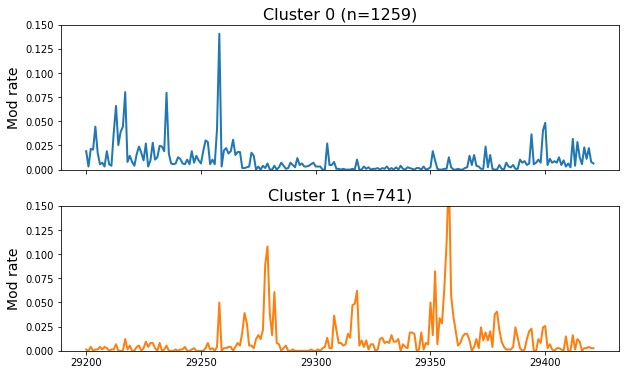

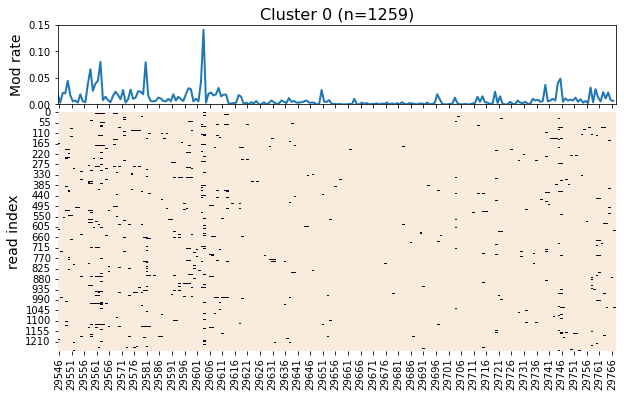

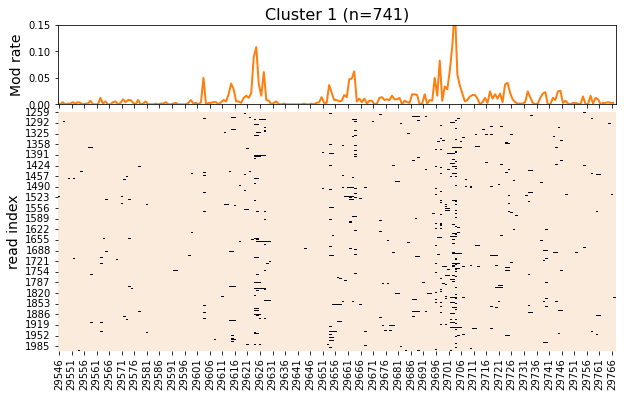

In [17]:
plot_window_long('')

In [ ]:
### chisquare  test ---  ----

In [21]:
### 3 groups compare --------------------------------

exp = [1410,590]
obs = [1241,759]
both = np.array([obs, exp])
chi2, p, dof, expected = stats.chi2_contingency(both)
print(p) 

exp = [1410,590]
obs = [1264,736]
both = np.array([obs, exp])
chi2, p, dof, expected = stats.chi2_contingency(both)
print(p) 

exp = [1241,759]
obs = [1264,736]
both = np.array([obs, exp])
chi2, p, dof, expected = stats.chi2_contingency(both)
print(p) 


### 3 groups compare to ensemble-------------------------

exp = [1259,741]
obs = [1241,759]
both = np.array([obs, exp])
chi2, p, dof, expected = stats.chi2_contingency(both)
print(p) 

exp = [1259,741]
obs = [1264,736]
both = np.array([obs, exp])
chi2, p, dof, expected = stats.chi2_contingency(both)
print(p) 

exp = [1259,741]
obs = [1410,590]
both = np.array([obs, exp])
chi2, p, dof, expected = stats.chi2_contingency(both)
print(p)

1.925062954356375e-08
1.1149333230843928e-06
0.4721416085618644
0.578745780684579
0.8957347781298451
4.819583800439005e-07
